# Installs

In [ ]:
import torch;

In [ ]:
pip install torchmetrics

In [ ]:
!pip install pytorch-lightning
!pip install torch-geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install jax
!pip install --upgrade jax jaxlib==0.4.20+cpu -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install tensorcircuit
!pip install qiskit
!pip install matplotlib
!pip install pylatexenc
!pip install tabulate
!pip install kmapper
!pip install qutip

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
ERROR: Ignored the following yanked versions: 0.4.32
ERROR: Could not find a version that satisfies the requirement jaxlib==0.4.20+cpu (from versions: 0.1.75+cuda11.cudnn805, 0.1.75+cuda11.cudnn82, 0.1.76+cuda11.cudnn805, 0.1.76+cuda11.cudnn82, 0.3.0+cuda11.cudnn805, 0.3.0+cuda11.cudnn82, 0.3.2+cuda11.cudnn805, 0.3.2+cuda11.cudnn82, 0.3.5+cuda11.cudnn805, 0.3.5+cuda11.cudnn82, 0.3.7+cuda11.cudnn805, 0.3.7+cuda11.cudnn82, 0.3.8+cuda11.cudnn805, 0.3.8+cuda11.cudnn82, 0.3.10+cuda11.cudnn805, 0.3.10+cuda11.cudnn82, 0.3.14+cuda11.cudnn805, 0.3.14+cuda11.cudnn82, 0.3.15+cuda11.cudnn805, 0.3.15+cuda11.cudnn82, 0.3.18+cuda11.cudnn805, 0.3.18+cuda11.cudnn82, 0.3.20+cuda11.cudnn805, 0.3.20+cuda11.cudnn82, 0.3.22+cuda11.cudnn805, 0.3.22+cuda11.cudnn82, 0.3.24+cuda11.cudnn805, 0.3.24+cuda11.cudnn82, 0.3.25+cuda11.cudnn805, 0.3.25+cuda11.cudnn82, 0.4

In [ ]:
pip install --upgrade jax jaxlib==0.4.35

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Comment this to use gpu

In [ ]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
import torch_geometric.transforms as T

import torch
import torch.nn as nn
import qutip
from qutip import Bloch
import matplotlib
from matplotlib import pyplot as plt
import sklearn as skl
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelSummary
from pytorch_lightning.callbacks import Callback

from pytorch_lightning.loggers import WandbLogger

import jax
import jax.numpy as jnp
import tensorcircuit as tc

import numpy as np
import pandas as pd
import kmapper as km
import networkx as nx
from copy import copy

import warnings
warnings.filterwarnings('ignore')

torch.set_float32_matmul_precision("medium")
K = tc.set_backend("jax")
print(tc.__version__)

0.12.0


In [ ]:
jax.devices()

[CpuDevice(id=0)]

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


# VQC

In [ ]:
from jax import device_get

def get_circ(nqubits, nlayers, x, weights):
    # print(x.shape, x.val, x[1])
    c = tc.Circuit(nqubits)
    for i in range(nqubits):
        c.rx(i, theta=x[i])
    for j in range(nlayers):
        for i in range(nqubits - 1):
            c.cnot(i, i + 1)

        for i in range(nqubits):
            c.rx(i, theta=weights[2 * j, i])
            c.ry(i, theta=weights[2 * j + 1, i])
        # c.cnot(nqubits-1,0)
    return c

# test = None;

def circuit_wrapper(nqubits, nlayers):
    # print("IN THE CIRCUIT WRAPPER with ",nqubits,nlayers)
    # global test
    # We define the quantum function,
    # note how this function is running on jax
    def qpred(x, weights):
        nqubits=x.shape[0]
        # print("THIS IS BEING PRINTED")
        ### print("The shape of the X onside the qpred : ----> x.shape: ", x.shape, "x.dtype:", x.dtype)
        ### print("weights.shape:", weights.shape, "weights.dtype:", weights.dtype)
        # print("---------------------------------------------------------------------------------")
        ### Ensure x and weights are of float type
        x = x.astype(float)
        weights = weights.astype(float)

        circuit = get_circ(nqubits, nlayers, x, weights)
        # print(circuit,nqubits,nlayers)
        # print("The circuit was created; now on to the calculation")
        ### print("Sample values of x (as numpy array):", jnp.asarray(weights)[:5])# Print the first 5 values of x
        x_concrete = device_get(x)
        ###print("Sample values of x (concrete):", x_concrete[:5])
        # print("---------------------------------------------------------------------------------")
        expectations = []
        for i in range(nqubits):
            value = circuit.expectation_ps(z=[i])
            # print(f"Expectation value for qubit {i}:", value, "Type:", type(value))
            expectations.append(value)

        return K.real(jnp.array(expectations))


    # `qpred_vmap` is a jax function with vectorization capacity
    qpred_vmap = K.vmap(qpred, vectorized_argnums=0)

    # Wrap the function into pytorch form but with jax speed!
    qpred_batch = tc.interfaces.torch_interface(qpred_vmap, jit=True)

    return qpred_batch

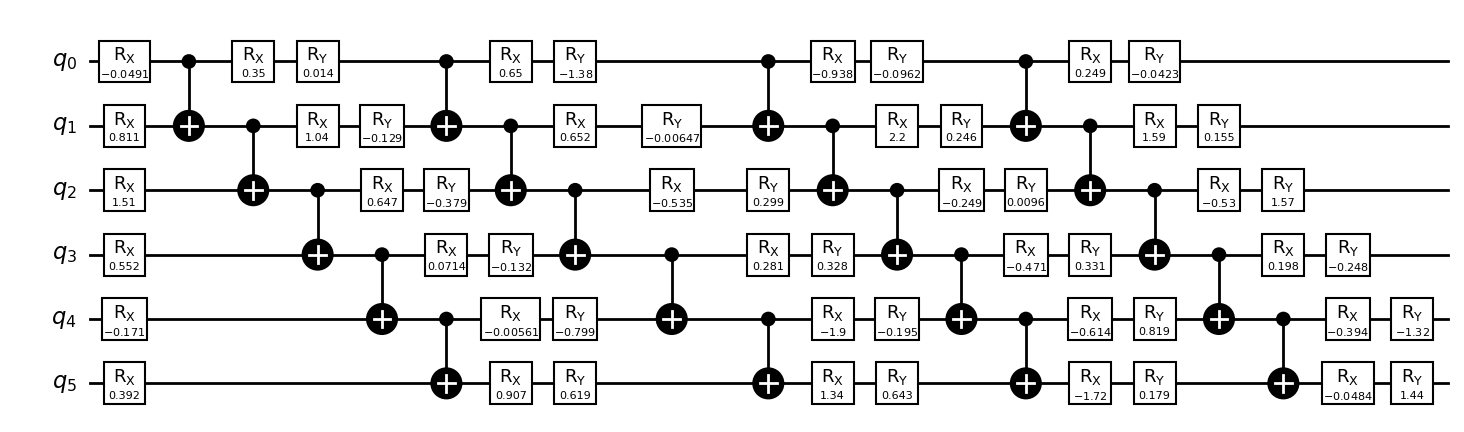

In [ ]:
# Test the AD capacity of the PyTorch function
nqubits = 6
nlayers = 4
w = torch.randn([2 * nlayers, nqubits])
dummy_x = torch.randn([3, nqubits])

fig = get_circ(nqubits, nlayers, dummy_x[0], w).draw(output='mpl', style="bw", fold=0)
fig.savefig('Quantum_circ.pdf', format='pdf', dpi=300, bbox_inches='tight');
fig

In [ ]:
qpred_batch = circuit_wrapper(nqubits, nlayers)

In [ ]:
w.requires_grad_()
with torch.set_grad_enabled(True):
    print(dummy_x.shape, dummy_x)
    yps = qpred_batch(dummy_x, w)
    loss = torch.sum(yps)
    loss.backward()
print(w.grad, yps)

torch.Size([3, 6]) tensor([[-0.0491,  0.8112,  1.5143,  0.5520, -0.1708,  0.3920],
        [ 0.2514,  1.2225,  0.5555, -0.3610,  1.7462,  0.7868],
        [ 0.8798, -1.5524,  0.3215, -1.2130,  0.5518, -0.3990]])
tensor([[-4.9458e-01,  1.9852e-01, -3.9963e-01,  4.3692e-01, -3.5265e-01,
          7.8293e-01],
        [-1.3289e-04, -6.0859e-02,  5.0144e-01, -1.7720e-02,  5.8188e-01,
         -2.8423e-01],
        [-3.3308e-01,  6.8426e-01,  9.5737e-02, -1.0794e-02,  1.0159e-01,
         -7.6203e-02],
        [ 8.4132e-01,  3.2920e-01, -3.7228e-01,  8.3991e-01,  2.4604e-01,
          3.3262e-01],
        [-4.0997e-01, -5.5346e-02,  3.4345e-01, -7.9295e-03,  9.3873e-02,
         -4.0256e-02],
        [-2.5554e-01,  1.9053e-02,  5.2147e-03,  1.5831e-01,  4.5816e-01,
         -1.7258e-01],
        [-2.0478e-01,  3.8900e-01,  1.2881e-04,  1.8520e-01, -3.8472e-02,
         -1.4299e-02],
        [ 1.8425e-01, -2.9612e-02, -1.3558e-01,  6.0703e-02,  3.9512e-01,
         -8.9011e-03]]) tensor([[ 0

In [ ]:
class QuantumNet(nn.Module):
    def __init__(self, nqubits, nlayers):
        super().__init__()
        self.q_weights = torch.nn.Parameter(torch.randn([2 * nlayers, nqubits]))
        self.qpred_batch = circuit_wrapper(nqubits, nlayers)

        self.nqubits = nqubits
        self.nlayers = nlayers

    def forward(self, inputs):
        ### inputs=[]
        self.nqubits = inputs.shape[1]
        #### inputs_local = torch.randn(32, input_dim)
        # print("Inside QuantumNet the size of the input that are in here:------>", inputs.shape)
        # ## #print(inputs)
        # print(inputs.dtype)
        # print(type(inputs))
        # ### print(self.q_weights)
        # print(self.q_weights.dtype)
        # print(type(self.q_weights))

        # print("---------------------------------------------------------------------------------")

        # print("Now going to the qbred_batch with variables ",inputs, self.q_weights)
        # print("---------------------------------------------------------------------------------")

        ypred = self.qpred_batch(inputs, self.q_weights)
        # print("output of qpred", ypred.shape)
        return ypred

In [ ]:
# Define parameters
nqubits = 8
nlayers = 3
input_dim = 10
output_dim = nqubits  # Since ypred has one expectation value per qubit

# Instantiate the model
model = QuantumNet(nqubits, nlayers)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Dummy data
inputs = torch.randn(32, input_dim)  # Batch of 32 samples
targets = torch.randn(32, nqubits)  # Corresponding targets

# Training step
model.train()
optimizer.zero_grad()
outputs = model(inputs)
# loss = criterion(outputs, targets)
# loss.backward()
# optimizer.step()

print(outputs)


tensor([[ 3.3952e-01,  9.9841e-02, -3.3591e-01, -3.2607e-02, -1.2403e-01,
          1.5461e-01, -4.4283e-01, -2.0261e-01,  7.2703e-02, -5.9371e-02],
        [ 4.0450e-01, -6.2948e-02,  1.1136e-01,  2.8171e-02, -1.1950e-01,
         -3.8922e-02, -1.6612e-01, -2.6840e-01,  1.1628e-01, -3.1248e-03],
        [ 1.8495e-01, -1.4581e-01, -9.1230e-03, -5.9948e-03, -7.0705e-03,
          1.1607e-01, -2.7250e-01, -1.4502e-01,  2.1648e-01,  1.1149e-04],
        [ 2.1912e-01,  4.6610e-02, -4.7001e-02, -2.0904e-02,  2.2644e-02,
          8.1629e-02, -3.4522e-01, -1.8270e-01, -1.2983e-01, -1.1379e-03],
        [ 4.6115e-01,  1.0185e-01, -6.2021e-02, -1.6867e-02, -8.1170e-03,
         -4.5108e-03, -3.1992e-01, -2.0920e-01,  8.7258e-02,  1.4246e-02],
        [ 1.9009e-01,  4.2294e-02, -1.4860e-01, -1.7404e-02, -6.0212e-02,
          9.4663e-02, -4.1414e-01, -4.3063e-01,  5.7708e-02, -1.5544e-01],
        [ 2.1929e-01,  1.9059e-01, -1.8305e-01, -1.0360e-02, -2.0225e-02,
          1.4314e-01, -4.5115e-0

In [ ]:
print(type(inputs))
print(inputs.dtype)

<class 'torch.Tensor'>
torch.float32


In [ ]:
print(inputs.shape)

torch.Size([32, 10])


In [ ]:
net = QuantumNet(6, 2)
out = net(dummy_x)
print(out)
print(out.shape)

tensor([[-0.0699, -0.1932, -0.0586, -0.1126,  0.1096, -0.0379],
        [-0.0368, -0.2561, -0.1871, -0.0143,  0.1767, -0.0296],
        [ 0.0435,  0.3554,  0.1072, -0.0585,  0.2044, -0.0248]],
       grad_fn=<FunBackward>)
torch.Size([3, 6])


In [ ]:
class QGCNConv(geom_nn.GCNConv):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True,
        normalize: bool = True,
        bias: bool = True,
        nlayers=1,
        **kwargs,
    ):
        super().__init__(in_channels,
                         out_channels,
                         improved,
                         cached,
                         add_self_loops,
                         normalize,
                         bias,
                         **kwargs)
        # Ensure QuantumNet outputs match out_channels
        ## out_channels === qubits
        self.qnet = QuantumNet(out_channels, nlayers)

    def forward(self, x, edge_index, edge_weight=None):
        # Apply the GCNConv operation
        # print("In the QGCN layer, the size of the inpu X that I wanna use for training:----> ",x.shape)
        # x = super().forward(x, edge_index, edge_weight)
        # Pass through the QuantumNet layer
        x = self.qnet(x)
        return x


In [ ]:
import torch
from torch_geometric.data import Data

# Define dummy data for testing
num_nodes = 5
in_channels = 10
out_channels = 6
nlayers = 2

# Create dummy node features and edge indices
x = torch.randn(num_nodes, in_channels)  # Node features
edge_index = torch.tensor([[0, 1, 2, 3, 4], [1, 2, 3, 4, 0]])  # Edge indices

# Instantiate QGCNConv layer
layer = QGCNConv(in_channels, out_channels, nlayers=nlayers)

# Forward pass
output = layer(x, edge_index)

# Print the input and output for verification
print("Input shape:", x.shape)
print("Output shape:", output.shape)
print("Output:", output)


Input shape: torch.Size([5, 10])
Output shape: torch.Size([5, 10])
Output: tensor([[ 0.4359,  0.0548, -0.0708,  0.1807, -0.2319, -0.1467, -0.5137,  0.0671,
         -0.7318,  0.1886],
        [ 0.4415,  0.4647,  0.1980, -0.2120, -0.7253, -0.7434,  0.4568, -0.3757,
         -0.5826,  0.0811],
        [ 0.4226, -0.4847, -0.3305, -0.4577, -0.3631, -0.2657, -0.3845, -0.3720,
         -0.1365, -0.1621],
        [ 0.2203,  0.8099,  0.6154, -0.4000, -0.2290, -0.7132, -0.7394, -0.6098,
         -0.4504, -0.0344],
        [ 0.4044,  0.7342,  0.5465, -0.5743,  0.1454, -0.1455, -0.7137, -0.5840,
         -0.7762,  0.0551]], grad_fn=<FunBackward>)


# Datasets

## Functions

In [ ]:
def count_fraud_percentage(df, fraud_col='isFraud'):
    """
    Calculate the count and percentage of fraud cases in a DataFrame.

    """

    fraud_count = df[fraud_col].sum()

    total_count = len(df)
    fraud_percentage = (fraud_count / total_count) * 100

    return fraud_count, fraud_percentage

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

from imblearn.over_sampling import SMOTE
import pandas as pd

def balance_with_smote(df, target_col='isFraud', smote_ratio=0.2, random_state=42):
    """Apply SMOTE to increase the minority class size by a specified ratio."""
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Apply SMOTE with a limited ratio
    smote = SMOTE(sampling_strategy=smote_ratio, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
    balanced_df[target_col] = y_resampled
    return balanced_df

## PaySim Dataset

#### Loading PaySim Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Install the Kaggle library
!pip install kaggle

# Upload kaggle.json file
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json

# Make a directory for Kaggle and move the file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Now you can download the dataset
!kaggle datasets download -d ealaxi/paysim1 -p /content/datasets --unzip

print("Dataset downloaded to: /content/datasets")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
 97% 173M/178M [00:01<00:00, 94.8MB/s]
100% 178M/178M [00:01<00:00, 117MB/s] 
Dataset downloaded to: /content/datasets


In [ ]:
# df=pd.read_csv("/content/datasets/PS_20174392719_1491204439457_log.csv",delimiter=',')
# nRowsRead = 1000000
# big_df = pd.read_csv("/content/datasets/PS_20174392719_1491204439457_log.csv",delimiter=',',nrows=nRowsRead)
nRowsRead = 200000
small_df = pd.read_csv("/content/datasets/PS_20174392719_1491204439457_log.csv",delimiter=',',nrows=nRowsRead)

In [ ]:
# print(df.head())
# print(big_df.head())
print(small_df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


#### Cleaning

In [ ]:
df_cleaned = small_df.loc[(small_df['type'].isin(['CASH_OUT', 'TRANSFER'])),:]

In [ ]:
df_cleaned.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [ ]:
df_cleaned.drop(columns=['nameOrig','nameDest','isFlaggedFraud'],inplace=True)

In [ ]:
df_cleaned['type'] = small_df['type'].map({'CASH_OUT': 0, 'TRANSFER': 1})

In [ ]:
df_cleaned

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,1.0,181.00,181.0,0.00,0.00,0.00,1
3,1,0.0,181.00,181.0,0.00,21182.00,0.00,1
15,1,0.0,229133.94,15325.0,0.00,5083.00,51513.44,0
19,1,1.0,215310.30,705.0,0.00,22425.00,0.00,0
24,1,1.0,311685.89,10835.0,0.00,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...
199993,13,0.0,237574.30,1490404.6,1252830.30,673067.21,1531131.79,0
199994,13,0.0,20396.08,31618.0,11221.92,0.00,20396.08,0
199997,13,0.0,147125.05,0.0,0.00,1058502.64,1325544.47,0
199998,13,0.0,97529.67,0.0,0.00,1921846.97,2019376.64,0


Now we have to balance the dataset since the original is way to unbalanced. To do this we use the smote methodology

In [ ]:
df_smote_balanced = balance_with_smote(df_cleaned, target_col='isFraud', smote_ratio=0.25, random_state=42)
fraud_count_smote, fraud_percentage_smote = count_fraud_percentage(df_smote_balanced)
print(f"After SMOTE - Fraudulent: {fraud_count_smote}, Fraud Percentage: {fraud_percentage_smote:.2f}%")

After SMOTE - Fraudulent: 20794, Fraud Percentage: 20.00%


In [ ]:
final_df=df_smote_balanced

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
final_df[final_df.columns] = scaler.fit_transform(final_df[final_df.columns])


In [ ]:
print(type(final_df))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
final_df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,0.000000,1.000000,0.000018,0.000011,0.0,0.000000,0.000000,1.0
1,0.000000,0.000000,0.000018,0.000011,0.0,0.000544,0.000000,1.0
2,0.000000,0.000000,0.022913,0.000938,0.0,0.000131,0.001319,0.0
3,0.000000,1.000000,0.021531,0.000043,0.0,0.000576,0.000000,0.0
4,0.000000,1.000000,0.031168,0.000663,0.0,0.000161,0.069647,0.0
...,...,...,...,...,...,...,...,...
103966,0.166667,0.000000,0.014918,0.000183,0.0,0.000098,0.003845,1.0
103967,0.416667,1.000000,0.002175,0.001331,0.0,0.000000,0.000000,1.0
103968,0.500000,0.477694,0.000016,0.000010,0.0,0.000055,0.000000,1.0
103969,0.583333,1.000000,0.115415,0.070663,0.0,0.000000,0.000277,1.0


# Models

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

In [ ]:
import torch.nn as nn
import torch_geometric.nn as geom_nn  # Assuming PyTorch Geometric is being used
from torch_geometric.nn import SAGEConv
class GraphGNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, use_qgcn, dp_rate_linear=0.5, dp_rate=0.4, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
            dp_rate - Dropout rate inside the GNN layers
            kwargs - Additional arguments for the GNNModel object
        """
        super().__init__()
        self.use_qgcn = use_qgcn
        # self.embed = nn.Linear(c_in, c_hidden)
        qin=c_in
        qout=qin
        self.QGCN = QGCNConv(qin, qout, nlayers=5)

        # Dropout layer with 0.3 dropout rate
        self.dropout = nn.Dropout(dp_rate)

        self.head_true = nn.Sequential(
            nn.Linear(qout, c_out)
        )

        self.head_false = nn.Sequential(
            nn.Linear(c_hidden, c_out)
        )


        # Define GCN layers
        self.gcn1 = GCNConv(
            in_channels=qout,  # Input features dimension
            out_channels=c_hidden,  # Hidden layer dimension
            bias=False  # Optional: Remove bias for simplicity
        )
        self.gcn2 = GCNConv(
            in_channels=c_hidden,  # Hidden layer dimension
            out_channels=c_hidden,  # Output features dimension
            bias=False
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph
            (PyTorch geometric notation)
            batch_idx - Index of batch element for each node
        """
        # Embedding layer
        # x = self.embed(x)

        if self.use_qgcn==0:
            # print("QGCN layer is being applied.")
            x = self.QGCN(x, edge_index)
            # print("QGCN layer is skipped.")
                    # Pooling layer
            x = geom_nn.global_mean_pool(x, batch_idx)  # Average pooling at graph level feature

            # Output head
            x = self.head_true(x)
            return x  # one row per graph (transaction)

        elif self.use_qgcn==1:
            x = self.QGCN(x, edge_index)
            x = self.gcn1(x, edge_index)
            x = self.dropout(x)  # Apply dropout after the first GCN layer
            x = self.gcn2(x, edge_index)
            x = self.dropout(x)

            # Pooling layer
            x = geom_nn.global_mean_pool(x, batch_idx)  # Average pooling at graph level feature

            # Output head
            x = self.head_false(x)
            return x  # one row per graph (transaction)

        else:
            x = self.gcn1(x, edge_index)
            x = self.dropout(x)  # Apply dropout after the first GCN layer
            x = self.gcn2(x, edge_index)
            x = self.dropout(x)

            # Pooling layer
            x = geom_nn.global_mean_pool(x, batch_idx)  # Average pooling at graph level feature

            # Output head
            x = self.head_false(x)
            return x  # one row per graph (transaction)




# Training

## Preparing

In [ ]:
final_df = final_df.sort_values(by='step').astype(float)

In [ ]:
import torch
from sklearn.metrics.pairwise import cosine_similarity

def create_edge_index(features, threshold=0.5):

    num_nodes = features.size(0)
    edge_list = []

    similarity_matrix = cosine_similarity(features.numpy())

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j or similarity_matrix[i, j] >= threshold:
                # Add an edge if above threshold or self-loop
                edge_list.append([i, j])

    edge_index = torch.tensor(edge_list, dtype=torch.long).t()  # Convert to COO format
    return edge_index


In [ ]:
from torch_geometric.data import Data

def preprocess_data(final_df, threshold=0.5):
    data_list = []

    features = final_df.drop(columns=['isFraud']).astype(float).values
    labels = final_df['isFraud'].astype(int).astype(float).values

    for i in range(len(features)):
        x = torch.tensor(features[i], dtype=torch.float).unsqueeze(0)  # Single-node feature
        edge_index = create_edge_index(x, threshold)  # Create edges based on similarity
        y = torch.tensor(labels[i], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

    return data_list


In [ ]:
data_list = preprocess_data(final_df, threshold=0.8)

In [ ]:
train_val_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)

for data in train_data[:5]:  # Check the first 5 data objects for type consistency
    print(f"x dtype: {data.x.dtype}, y dtype: {data.y.dtype}")

x dtype: torch.float32, y dtype: torch.int64
x dtype: torch.float32, y dtype: torch.int64
x dtype: torch.float32, y dtype: torch.int64
x dtype: torch.float32, y dtype: torch.int64
x dtype: torch.float32, y dtype: torch.int64


In [ ]:
from torch_geometric.loader import DataLoader

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
import pandas as pd
import torchmetrics
from torchmetrics import Accuracy
from torch.optim import Adam
import pytorch_lightning as pl
import torch.nn as nn

# Global metrics storage
epoch_metrics_list = []

class QuantumGraphClassifier(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()  # Adjust for your task
        self.lr = lr

        # Metrics
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)

    def forward(self, x, edge_index, batch_idx):
        return self.model(x, edge_index, batch_idx)

    def training_step(self, batch, batch_idx):
        out = self(batch.x, batch.edge_index, batch.batch)
        loss = self.loss_fn(out, batch.y)

        # Update training accuracy
        self.train_acc.update(out.argmax(dim=1), batch.y)
        self.log("train_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        # Log and store train accuracy
        train_acc = self.train_acc.compute()
        epoch_metrics_list.append({
            "epoch": self.current_epoch,
            "train_acc": train_acc.item()
        })
        self.train_acc.reset()
        print(f"Epoch {self.current_epoch}: Train Accuracy: {train_acc.item():.4f}")

    def on_validation_epoch_end(self):
        # Log and store validation accuracy
        val_acc = self.val_acc.compute()
        if epoch_metrics_list and len(epoch_metrics_list) > self.current_epoch:
            epoch_metrics_list[self.current_epoch]["val_acc"] = val_acc.item()
        else:
            epoch_metrics_list.append({
                "epoch": self.current_epoch,
                "val_acc": val_acc.item()
            })
        self.val_acc.reset()
        print(f"Epoch {self.current_epoch}: Validation Accuracy: {val_acc.item():.4f}")

    def validation_step(self, batch, batch_idx):
        out = self(batch.x, batch.edge_index, batch.batch)
        loss = self.loss_fn(out, batch.y)

        # Update validation accuracy
        self.val_acc.update(out.argmax(dim=1), batch.y)
        self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        out = self(batch.x, batch.edge_index, batch.batch)
        loss = self.loss_fn(out, batch.y)

        # Update test accuracy
        self.test_acc.update(out.argmax(dim=1), batch.y)
        self.log("test_loss", loss, on_epoch=True, on_step=False, prog_bar=True)

    def on_test_epoch_end(self):
        # Log test accuracy
        test_acc = self.test_acc.compute()
        self.log("test_acc_epoch", test_acc, prog_bar=True)
        self.test_acc.reset()

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

def get_metrics_table():
    """Return a Pandas DataFrame of epoch metrics."""
    return pd.DataFrame(epoch_metrics_list)

# Example Usage
# Instantiate your model and trainer here


## Executing

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

def test_model(pl_model, test_loader):
    pl_model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for testing
        for batch in test_loader:
            # Forward pass using x, edge_index, and batch for the model
            out = pl_model(batch.x, batch.edge_index, batch.batch)

            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())  # Move to CPU and store predictions
            all_labels.extend(batch.y.cpu().numpy())  # Move to CPU and store true labels

    # Print the classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["0", "1"], digits=4))

    # Print the confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    print(cm)

In [ ]:
# Define a function to train and test the model with a given use_qgcn setting
def run_experiment(use_qgcn,epochs):
    # Reset the global metrics storage
    global epoch_metrics_list
    epoch_metrics_list = []

    # Instantiate the model
    c_in, c_hidden, c_out = 7, 32, 2  # Example dimensions
    model = GraphGNNModel(c_in=c_in, c_hidden=c_hidden, c_out=c_out, use_qgcn=use_qgcn)

    model = QuantumGraphClassifier(model)

    # Set up the trainer
    trainer = pl.Trainer(max_epochs=epochs, accelerator="gpu" if torch.cuda.is_available() else "cpu")

    # Train the model
    print(f"Running experiment with use_qgcn={use_qgcn}...")
    trainer.fit(model, train_loader, val_loader)

    # Test the model
    trainer.test(model, test_loader)

    # Convert metrics to a DataFrame and return
    metrics_df = get_metrics_table()
    metrics_df["use_qgcn"] = use_qgcn  # Add a column to indicate the setting
    return model,metrics_df

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | GraphGNNModel      | 1.5 K  | train
1 | loss_fn   | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Running experiment with use_qgcn=0...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.1562


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.8194
Epoch 0: Train Accuracy: 0.7603


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Validation Accuracy: 0.8702
Epoch 1: Train Accuracy: 0.8608


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Validation Accuracy: 0.8804
Epoch 2: Train Accuracy: 0.8821


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Validation Accuracy: 0.8794
Epoch 3: Train Accuracy: 0.8869


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Validation Accuracy: 0.8937
Epoch 4: Train Accuracy: 0.8903


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: Validation Accuracy: 0.8883
Epoch 5: Train Accuracy: 0.8944


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: Validation Accuracy: 0.8929
Epoch 6: Train Accuracy: 0.8973


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: Validation Accuracy: 0.8895
Epoch 7: Train Accuracy: 0.9017


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: Validation Accuracy: 0.9043
Epoch 8: Train Accuracy: 0.9046


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: Validation Accuracy: 0.9078
Epoch 9: Train Accuracy: 0.9064


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9069968461990356     │
│         test_loss         │     0.267209529876709     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | GraphGNNModel      | 1.5 K  | train
1 | loss_fn   | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Running experiment with use_qgcn=1...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.1562


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.8815
Epoch 0: Train Accuracy: 0.8495


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Validation Accuracy: 0.9089
Epoch 1: Train Accuracy: 0.9012


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Validation Accuracy: 0.9241
Epoch 2: Train Accuracy: 0.9222


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Validation Accuracy: 0.9356
Epoch 3: Train Accuracy: 0.9337


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Validation Accuracy: 0.9342
Epoch 4: Train Accuracy: 0.9396


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: Validation Accuracy: 0.9436
Epoch 5: Train Accuracy: 0.9412


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: Validation Accuracy: 0.9360
Epoch 6: Train Accuracy: 0.9410


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: Validation Accuracy: 0.9475
Epoch 7: Train Accuracy: 0.9430


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: Validation Accuracy: 0.9430
Epoch 8: Train Accuracy: 0.9428


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: Validation Accuracy: 0.9491
Epoch 9: Train Accuracy: 0.9445


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9511420726776123     │
│         test_loss         │    0.16828376054763794    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | GraphGNNModel      | 1.5 K  | train
1 | loss_fn   | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Running experiment with use_qgcn=2...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.1562


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.8850
Epoch 0: Train Accuracy: 0.8521


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Validation Accuracy: 0.9149
Epoch 1: Train Accuracy: 0.9030


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Validation Accuracy: 0.9249
Epoch 2: Train Accuracy: 0.9230


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Validation Accuracy: 0.9303
Epoch 3: Train Accuracy: 0.9315


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Validation Accuracy: 0.9368
Epoch 4: Train Accuracy: 0.9366


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: Validation Accuracy: 0.9356
Epoch 5: Train Accuracy: 0.9390


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: Validation Accuracy: 0.9379
Epoch 6: Train Accuracy: 0.9397


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: Validation Accuracy: 0.9456
Epoch 7: Train Accuracy: 0.9405


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: Validation Accuracy: 0.9407
Epoch 8: Train Accuracy: 0.9403


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: Validation Accuracy: 0.9347
Epoch 9: Train Accuracy: 0.9407


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9386872053146362     │
│         test_loss         │    0.17703276872634888    │
└───────────────────────────┴───────────────────────────┘

    epoch   val_acc  train_acc  use_qgcn
0       0  0.819371        NaN         0
1       0  0.870203   0.760315         0
2       1  0.880398   0.860793         0
3       2  0.879388   0.882097         0
4       3  0.893719   0.886923         0
5       4  0.888285   0.890273         0
6       5  0.892854   0.894393         0
7       6  0.889535   0.897294         0
8       7  0.904347   0.901686         0
9       8  0.907810   0.904620         0
10      9       NaN   0.906383         0
0       0  0.881504        NaN         1
1       0  0.908916   0.849476         1
2       1  0.924113   0.901189         1
3       2  0.935558   0.922205         1
4       3  0.934164   0.933683         1
5       4  0.943590   0.939646         1
6       5  0.935991   0.941217         1
7       6  0.947485   0.941009         1
8       7  0.942964   0.943044         1
9       8  0.949120   0.942836         1
10      9       NaN   0.944535         1
0       0  0.885015        NaN         2
1       0  0.914

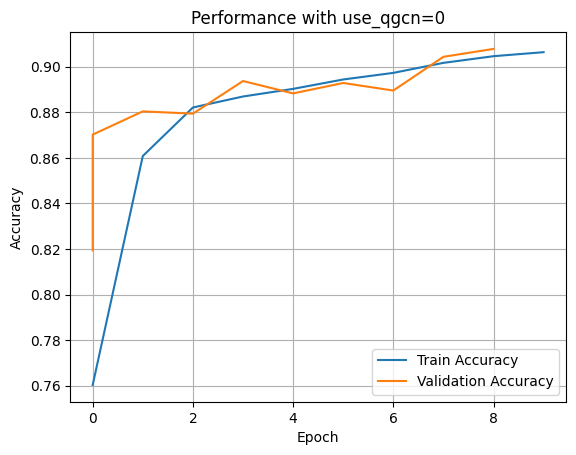

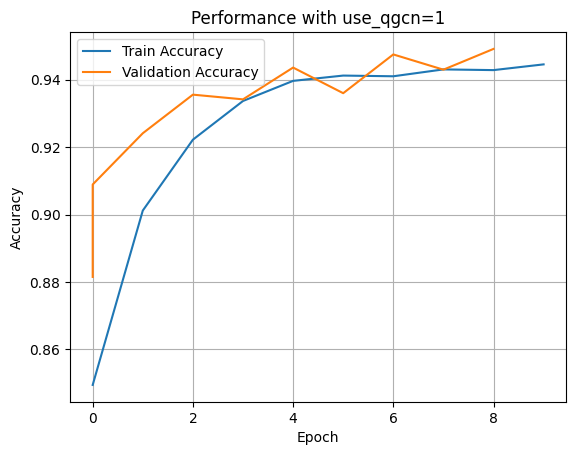

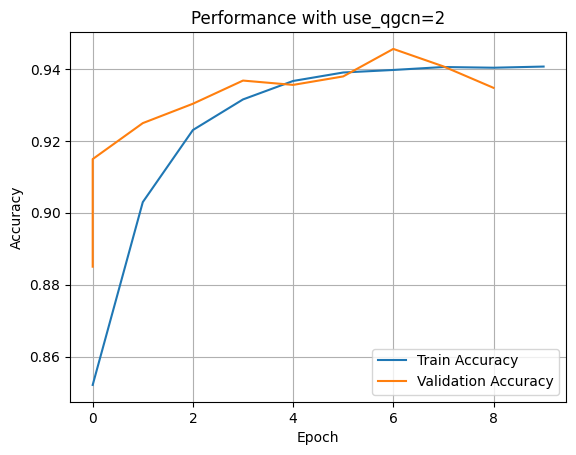

In [ ]:
# Run the experiments for use_qgcn=True and use_qgcn=False
quantum_model,metrics_quantum = run_experiment(use_qgcn=0,epochs=10)
hybrid_model,metrics_hybrid = run_experiment(use_qgcn=1,epochs=10)
classical_model,metrics_classic = run_experiment(use_qgcn=2,epochs=10)

# Combine the results into a single DataFrame
all_metrics_df = pd.concat([metrics_quantum, metrics_hybrid,metrics_classic])

# Save or display the results
print(all_metrics_df)
all_metrics_df.to_csv("qgcn_comparison_results.csv", index=False)

# Plot the results for comparison
import matplotlib.pyplot as plt

for use_qgcn, group in all_metrics_df.groupby("use_qgcn"):
    plt.figure()
    plt.plot(group["epoch"], group["train_acc"], label="Train Accuracy")
    plt.plot(group["epoch"], group["val_acc"], label="Validation Accuracy")
    plt.title(f"Performance with use_qgcn={use_qgcn}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
test_model(quantum_model, test_loader)

Classification Report:
              precision    recall  f1-score   support

           0     0.9182    0.9702    0.9435     16642
           1     0.8455    0.6537    0.7374      4153

    accuracy                         0.9070     20795
   macro avg     0.8819    0.8120    0.8404     20795
weighted avg     0.9037    0.9070    0.9023     20795


Confusion Matrix:
[[16146   496]
 [ 1438  2715]]


In [ ]:
test_model(classical_model, test_loader)

Classification Report:
              precision    recall  f1-score   support

           0     0.9415    0.9846    0.9626     16642
           1     0.9245    0.7546    0.8310      4153

    accuracy                         0.9387     20795
   macro avg     0.9330    0.8696    0.8968     20795
weighted avg     0.9381    0.9387    0.9363     20795


Confusion Matrix:
[[16386   256]
 [ 1019  3134]]


In [ ]:
test_model(hybrid_model, test_loader)

Classification Report:
              precision    recall  f1-score   support

           0     0.9606    0.9791    0.9698     16642
           1     0.9092    0.8392    0.8728      4153

    accuracy                         0.9511     20795
   macro avg     0.9349    0.9091    0.9213     20795
weighted avg     0.9504    0.9511    0.9504     20795


Confusion Matrix:
[[16294   348]
 [  668  3485]]
